In [27]:
## Online Retail II UCI Clustering with k-meas cluster algorithm
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import datetime as dt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/online-retail-ii-uci


In [8]:
data = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [10]:
# Festure engineering, i am going to be extracting relevant information from the data and i will trasform the data into a form that is more suitable for customer clustering


data = data[~data['Invoice'].astype(str).str.startswith('C')]  # remove cancellations
data = data.dropna(subset=['Customer ID'])  # remove rows that do not have customerID
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) # convert the Invoice data column to datetime

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


In [11]:
# Creating a total sum column which is the product of the price and the quantity of the purchase

data['TotalSum'] = data['Quantity'] * data['Price']

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSum
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [12]:
# Snapshot reference date (one day after last invoice)
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Recency Frequency Monetary aggregation per customer
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalSum': 'sum'                                         # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [13]:
# New Dataframe successfully created with three columns Recency (How recent the customer last purchase was)
# Frequency (How often the customer makes purchases)
# Monetary (The monetary value of their combined purchases)
# Thi new dataframe is meant to capture the entirety of a customer's behaviour, and here we have 5881 customers
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5881 non-null   int64  
 1   Frequency  5881 non-null   int64  
 2   Monetary   5881 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.8 KB


In [14]:
# replacing the customer IDs with sequence

# Reset index so Customer ID becomes a column
rfm = rfm.reset_index()

# Create a new sequential customer identifier
rfm.insert(0, 'customer_seq', range(1, len(rfm) + 1))

# drop the original Customer
rfm = rfm.drop(columns=['Customer ID'])

rfm.head()

,customer_seq,Recency,Frequency,Monetary
0,1,326,12,77556.46
1,2,2,8,5633.32
2,3,75,5,2019.40
3,4,19,4,4428.69
4,5,310,1,334.40


In [15]:
# setting the customer seq as the index
rfm = rfm.set_index('customer_seq')
rfm.index.name = 'CustomerSeq'

rfm.head()

,Recency,Frequency,Monetary
CustomerSeq,,,
1,326,12,77556.46
2,2,8,5633.32
3,75,5,2019.40
4,19,4,4428.69
5,310,1,334.40


In [16]:
# removing the outliers
# removing customers above the 90th percentile in any RFM metric
thresholds = rfm.quantile(0.90)
rfm_filtered = rfm[
    (rfm['Recency'] <= thresholds['Recency']) &
    (rfm['Frequency'] <= thresholds['Frequency']) &
    (rfm['Monetary'] <= thresholds['Monetary'])
]

In [17]:
# performing log transform to resuce the skew of the data
rfm_log = np.log1p(rfm_filtered)

In [18]:
# scaling the data
scaler = StandardScaler()
X_scaled_log = scaler.fit_transform(rfm_log)

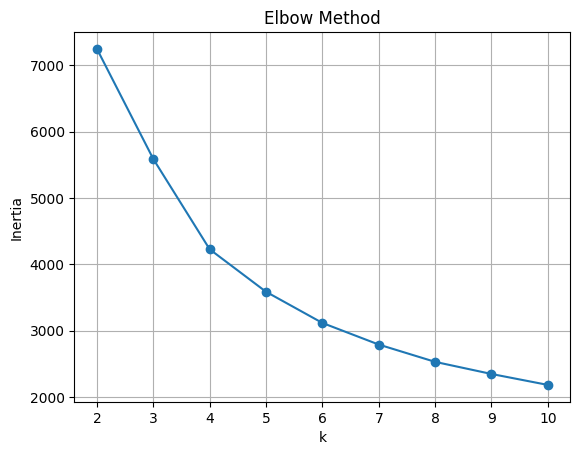

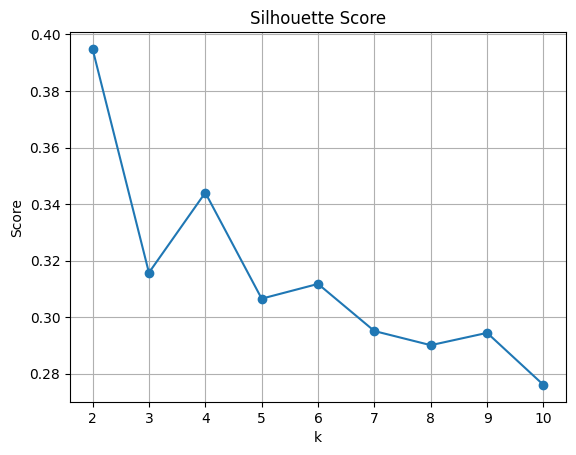

Best k by silhouette: 2


In [19]:
# Determining the best value for k (number of clusters) using elbow plot and silhouette plot

inertias = []
sil_scores = []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_log)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled_log, labels))

# Plot elbow
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plot silhouette
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)


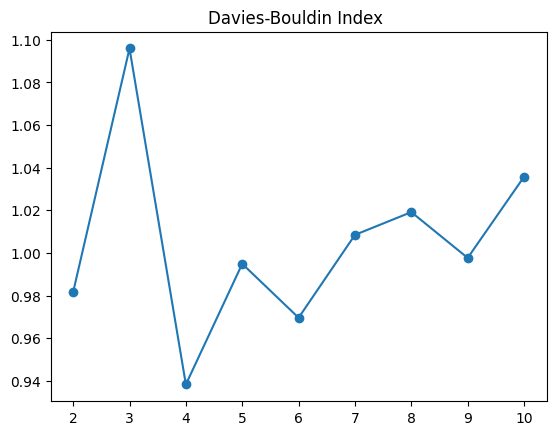

In [20]:
# I do not trust the results so i want to be extra sure, so i would also use the davies bouldin plot
from sklearn.metrics import davies_bouldin_score

scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_log)
    score = davies_bouldin_score(X_scaled_log, labels)
    scores.append(score)

plt.plot(range(2, 11), scores, marker='o')
plt.title("Davies-Bouldin Index ")
plt.show()


In [23]:
# from the bouldin plot best k should be 4
best_k = 4

# clustering the data
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled_log)
rfm_clustered = rfm_filtered.reset_index().copy()
rfm_clustered['cluster'] = cluster_labels



In [24]:
# Analyze clusters
print(rfm_clustered['cluster'].value_counts())
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
# invert log1p: expm1 to bring back to original RFM scale
centroid_df = pd.DataFrame(np.expm1(centroids), columns=rfm.columns)
print("Centroids (approx original scale):")
display(centroid_df)
print("Cluster means:")
display(rfm_clustered.groupby('cluster')[['Recency','Frequency','Monetary']].mean())


cluster
0    1313
2    1212
1    1088
3     944
Name: count, dtype: int64
Centroids (approx original scale):


,Recency,Frequency,Monetary
0,262.663396,1.269470,239.162492
1,22.579863,7.415564,2327.811058
2,212.478384,3.803976,1188.915009
3,23.607570,2.141306,542.291090


Cluster means:


,Recency,Frequency,Monetary
cluster,,,
0,308.667174,1.322163,302.767730
1,36.655331,7.808824,2603.287320
2,253.191419,4.099010,1386.778055
3,32.293432,2.304025,662.787142


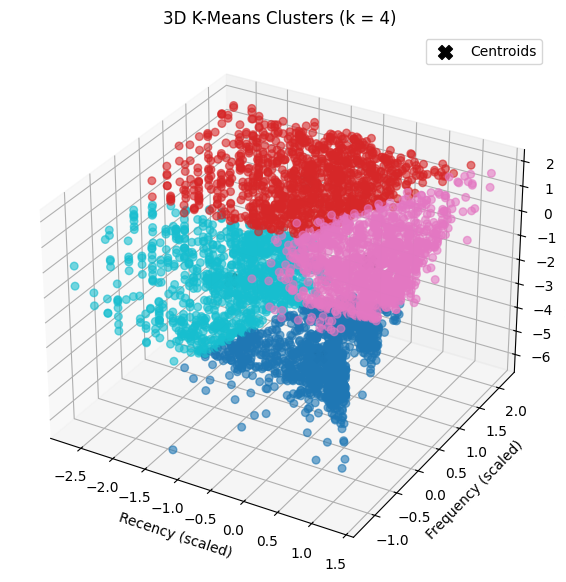

In [29]:
# making a 3D plot that shows the three features

x = X_scaled_log[:, 0]  # Recency
y = X_scaled_log[:, 1]  # Frequency
z = X_scaled_log[:, 2]  # Monetary
labels = cluster_labels

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    x, y, z,
    c=labels,
    cmap='tab10',
    alpha=0.6,
    s=30,
    depthshade=True
)

# Plot centroids (in scaled space)
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:,0], centroids[:,1], centroids[:,2],
    c='black',
    marker='X',
    s=100,
    label='Centroids'
)

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title(f'3D K-Means Clusters (k = 4)')
ax.legend()

# Optional: add colorbar for cluster labels if useful
plt.show()


In [30]:

# Prepare a copy for display: reset index so we can show customer identifier
rfm_display = rfm_filtered.reset_index().copy()
rfm_display['cluster'] = cluster_labels


# Coordinates in the scaled-log space
x = X_scaled_log[:, 0]  # Recency
y = X_scaled_log[:, 1]  # Frequency
z = X_scaled_log[:, 2]  # Monetary

# Centroids in the same space
centroids = kmeans.cluster_centers_

# hover texts
hover_texts = [
    (
        f"Customer: {row.get('customer_seq', row.name)}<br>"
        f"Recency: {row['Recency']:.1f}<br>"
        f"Frequency: {row['Frequency']:.1f}<br>"
        f"Monetary: {row['Monetary']:.2f}<br>"
        f"Cluster: {row['cluster']}"
    )
    for _, row in rfm_display.iterrows()
]

# Scatter for data points
scatter = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        showscale=True,
        opacity=0.7,
        colorbar=dict(title='Cluster')
    ),
    text=hover_texts,
    hoverinfo='text',
    name='Customers'
)

# Centroid trace
centroid_trace = go.Scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(
        size=12,
        symbol='x',
        color='black'
    ),
    name='Centroids',
    text=[f"Cluster {i}" for i in range(centroids.shape[0])],
    hoverinfo='text'
)

# Layout
layout = go.Layout(
    title=f"Interactive 3D K-Means Clusters (k={kmeans.n_clusters})",
    scene=dict(
        xaxis_title='Recency (log-scaled & standardized)',
        yaxis_title='Frequency (log-scaled & standardized)',
        zaxis_title='Monetary (log-scaled & standardized)',
    )
)

fig = go.Figure(data=[scatter, centroid_trace], layout=layout)
fig.show()
